In [6]:
import numpy as np
import pandas as pd

from IO.read_stereo import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [300]:
# Load the data
adata = read_gem_file('F:\Adult.gem', bin_size=40)

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

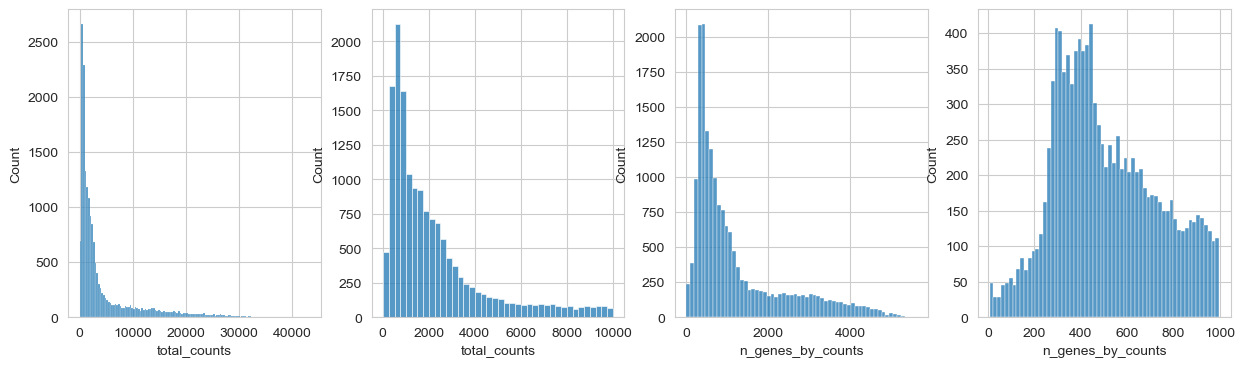

In [276]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=200)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [303]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [278]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=3000)
gene_list = list(adata.var[adata.var['highly_variable']].index)

In [279]:

from skimage import morphology
from tqdm import tqdm

new_list = []
for i in tqdm(gene_list, desc='Processing...'):
    matrix = get_exp_array(adata, i)
    eroded_image = morphology.erosion(matrix, np.ones((3, 3), dtype=np.bool_))
    if eroded_image.max() > 0:
        new_list.append(i)


Processing...: 100%|██████████| 3000/3000 [01:51<00:00, 26.81it/s]


In [280]:
len(new_list)

290

In [282]:
arr = build_gmm_distance_array(gmm_dict, method='optimized_match')

Building distance array...: 100%|██████████| 290/290 [09:30<00:00,  1.97s/it]


<AxesSubplot:ylabel='Count'>

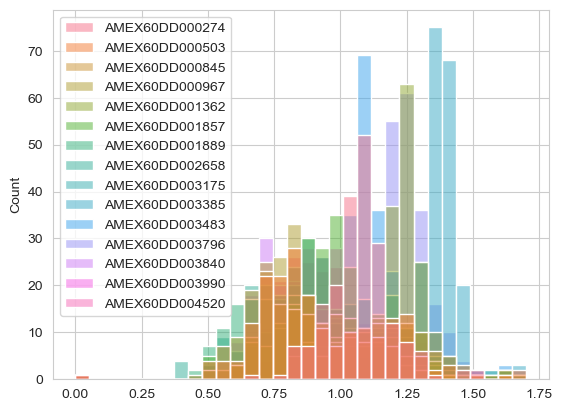

In [264]:
sns.histplot(arr[:15].T, cbar=False)

In [283]:
result = cluster_gene(arr, n_clusters=10, mds_components=50, method='kmeans')

F:\conda\envs\spatial\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
F:\conda\envs\spatial\lib\site-packages\sklearn\cluster_gene\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


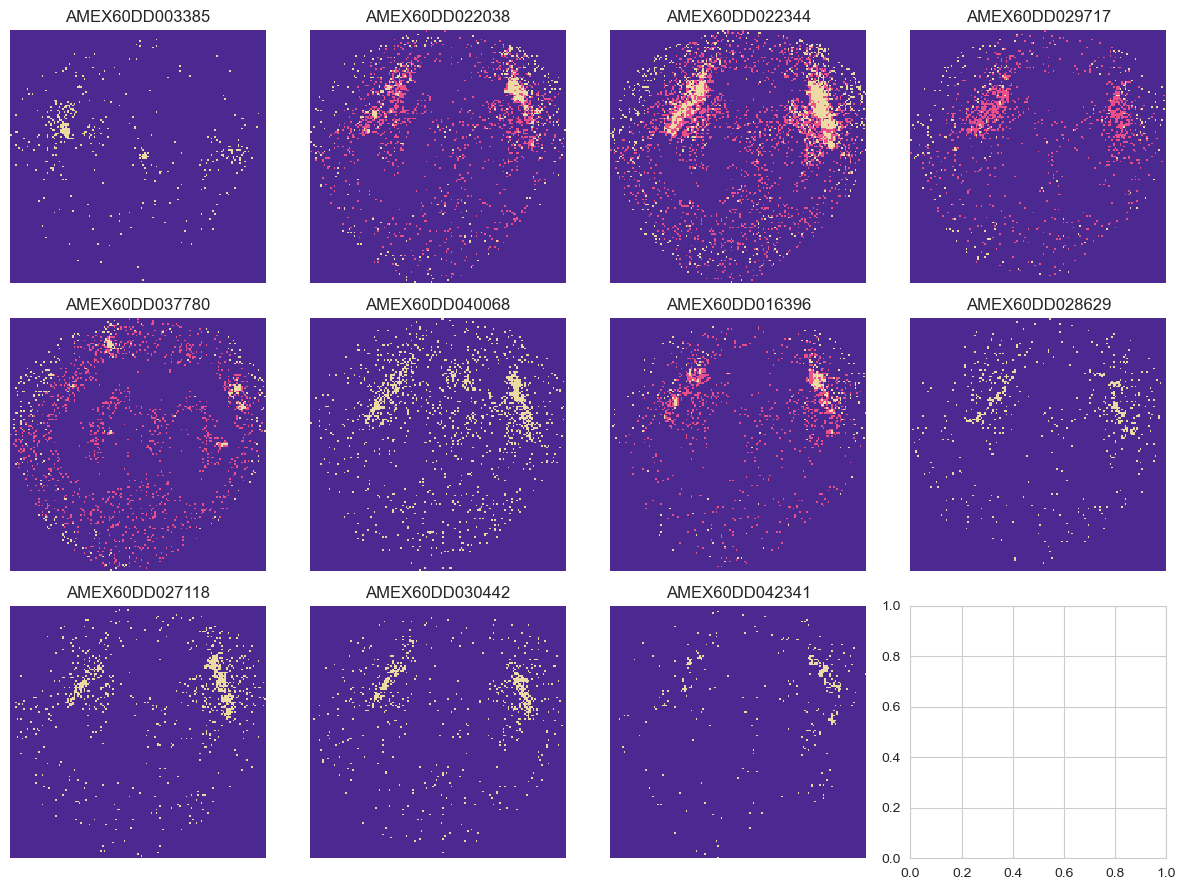

In [326]:
from Utils.plot import *
from palettable.cartocolors.sequential import agSunset_7

plot_genes(result,
             adata,
             label=7,
             vmax=99,
             num_cols=4,
             cmap=agSunset_7.mpl_colors
             )

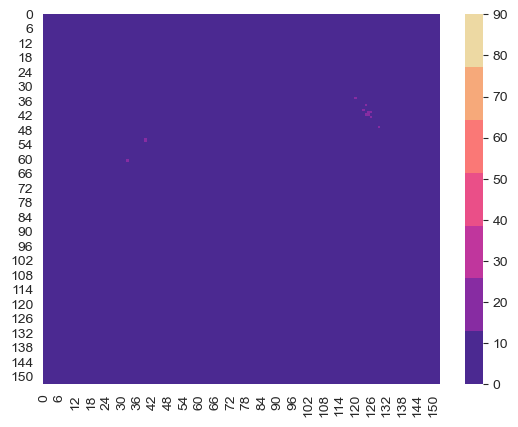

In [321]:
def plot_pattern(result, adata, label, cmap=None, vmax=99):
    li = list(result[result['labels'] == label]['gene_id'])
    total = np.zeros(get_exp_array(adata, li[0]).shape)
    for i in li:
        total += get_exp_array(adata, i)
    if cmap is not None:
        sns.heatmap(total, cmap=cmap, vmax=vmax)
    else:
        sns.heatmap(total, vmax=vmax)

plot_pattern(result,
             adata,
             7,
             vmax=90,
             cmap=agSunset_7.mpl_colors
             )

<AxesSubplot:>

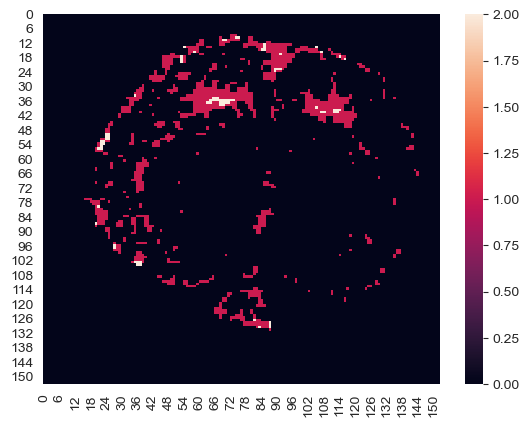

In [194]:
from skimage import morphology

fig, ax = plt.subplots()
matrix = get_exp_array(adata, 'AMEX60DD028725')
eroded_image = morphology.erosion(matrix, np.ones((3, 3), dtype=np.bool_))
sns.heatmap(eroded_image)


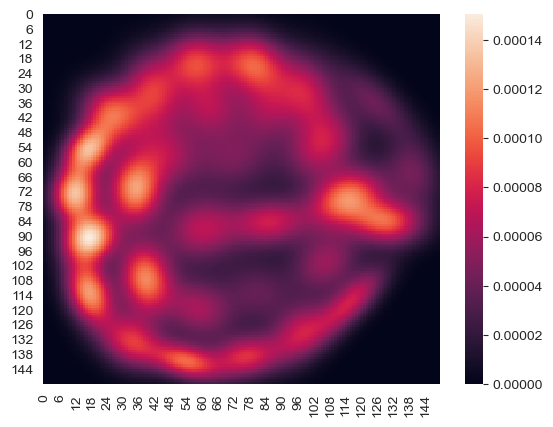

In [312]:

view_gmm(fit_gmm(adata, 'AMEX60DD028725',n_comp=30),scope=(0,150))